# HW2

In [1]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
%matplotlib inline

Using TensorFlow backend.


#### Implementing Simple Artificial Neural Network for multiclass classification

In [18]:
class SingleLayerNetwork:
    """ A single layer neural net for multiclass classification. """

    def __init__(self):
        self.weights = None
        self.bias = None
        self.learning_rate = None
        self.lr_decay = None

    def fit(self, X, y, epochs=10, learning_rate=1e-2, decay=0.5,
            batch_size=50, early_stopping=True, tol=1e-5):
        """
        Learns the net's parameters based on provided labelled data.
        
        :param X: the train objects
        :param y: the one-hot encoded classes of given objects
        :param epoch: the number of passes over the entire dataset
        :param learning_rate: size of gradient descent step
        :param decay: learning rate decay
        :param early_stopping: whether to stop training early 
                            when loss stops decreasing
        :param tol: 
        """
        # randomly initialize net's weights
        self._initialize_net(X, y, learning_rate, decay)
        loss = []

        for i in range(epochs):

            if (early_stopping and i > 0 and len(loss) > 5
                and np.abs(loss[-5] - np.mean(loss[-5:])) < tol):
                # average of loss decreased less than tol,
                # so stop training
                print("Stopped training after {0} epochs".format(i+1))
                break
                
            # shuffle data before each epoch
            _X, _y = shuffle(X, y)
            
            for batch_i in range(len(_X) // batch_size):
                # make a gradient descent step
                self._update_weights(_X[batch_i: batch_i + batch_size],
                                     _y[batch_i: batch_i + batch_size])
                
            # compute categorical cross-entropy loss
            loss.append(self._cross_entropy_loss(X, y))            
            
            # drop learning rate
            if i > 0 and not i % 10:
                self.learning_rate *= self.lr_decay
        
        return loss
    
    def _cross_entropy_loss(self, X, y):
        scores = self._predict(X)
        eps = 1e-30  # for numerical stability
        return -np.sum(np.log(scores * y + eps)) / len(y)


    def predict(self, X):
        """
        Predicts the class for given objects.
        
        :param X: an array of objects
        :returns: predicted classes of given objects in one-hot encoding
        """
        scores = self._predict(X)
        return self.labels[np.argmax(scores, axis=1)]

    def _predict(self, X):
        return self._softmax(X.dot(self.weights) + self.bias)

    def _update_weights(self, X, y):
        scores = self._predict(X)     # forward pass
        self._backprop(X, y, scores)  # gradient backpropagation

    def _backprop(self, X, y, scores):
        diff = scores - y
        self.weights -= self.learning_rate * X.T.dot(diff) / len(X)
        self.bias -= self.learning_rate * diff.sum(axis=0) / len(X)
    
    def _softmax(self, scores):
        e_x = np.exp(scores-(np.ones(scores.shape).T*scores.max(axis=1)).T)
        e_sum = (np.ones(e_x.shape).T * e_x.sum(axis=1)).T
        return e_x / e_sum
    
    def _initialize_net(self, X, y, learning_rate, decay):
        self.learning_rate = learning_rate
        self.lr_decay = decay
        self.labels = np.unique(y, axis=0)[::-1]

        # Glorot initialization of weights
        shape = (X.shape[1], len(self.labels))
        init_range = np.sqrt(6 / (shape[0] + shape[1]))
        self.bias = np.random.uniform(-init_range, init_range, 
                                      len(self.labels))
        self.weights = np.random.uniform(-init_range, init_range, shape)


#### Loading and visualizing the MNIST dataset

In [19]:
mnist = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


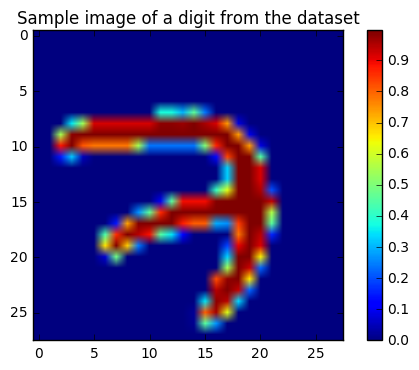

In [20]:
plt.imshow(mnist.train.images[0].reshape((28, 28)))
plt.title("Sample image of a digit from the dataset")
plt.colorbar()

#### Training the net to classify MNIST

In [21]:
# set up and train the net
net = SingleLayerNetwork()
loss = net.fit(mnist.train.images[:5000], mnist.train.labels[:5000],
               epochs=100, batch_size=10, learning_rate=0.01, decay=0.05)

Stopped training early after 36 epochs


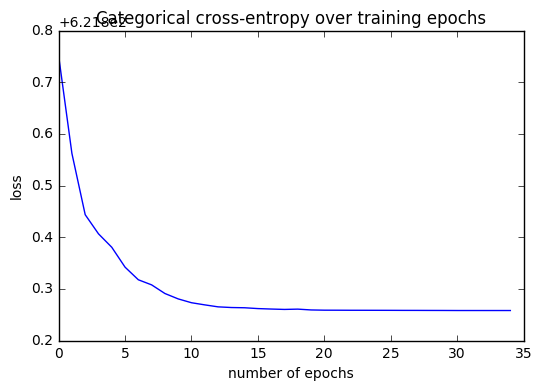

In [22]:
# visualize loss minimization over training epochs
plt.title("Categorical cross-entropy over training epochs")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.plot(range(len(loss)), loss)

In [23]:
# compute classification accuracy on test images
y_pred = net.predict(mnist.test.images)
y_true = mnist.test.labels
correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
print('Test accuracy:', 100 * correct / len(y_true), '%')

Test accuracy: 88.92 %


#### Comparing with Keras using TensorFlow backend

In [8]:
model = Sequential()
model.add(Dense(10, activation='softmax', input_shape=(784,)))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(), 
              metrics=['accuracy'])

In [9]:
model.fit(mnist.train.images[:5000], mnist.train.labels[:5000],
         batch_size=10, epochs=100, verbose=False)

In [16]:
score = model.evaluate(mnist.test.images, mnist.test.labels, verbose=0)
print('Test accuracy:', score[1] * 100, '%')

Test accuracy: 90.03 %
